In [4]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from dimredu.denseSolvers import denseToSparse as denseToSparse
from dimredu.sRPCAviaADMMFast import sRPCA as sRPCA

In [32]:
def get_fama_french_df(filename):
    """Load the data."""
    df = pd.read_csv(filename) 
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    return df.iloc[1:]

def get_scaled_lambda(m, n, _lambda):
    lam = 1. / np.sqrt(np.max([m, n]))
    return lam * _lambda

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_output_root_dir(dataset_type, input_type):
    output_root_dir = None
#     print("input_type: {0}", input_type)
#     print("dataset_type: {0}", dataset_type)
    if input_type == "returns":
        if "training" == dataset_type:
            output_root_dir = r'C:\phd\rpca\output\fama-french\returns\training'
        elif "validation" == dataset_type:
            output_root_dir = r'C:\phd\rpca\output\fama-french\returns\validation'
        else:
            output_root_dir = r'C:\phd\rpca\output\fama-french\returns\test'
    elif input_type == "euclidean-distances":
        if "training" == dataset_type:
            output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\training'
        elif "validation" == dataset_type:
            output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\validation'
        else:
            output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\test'        
    return output_root_dir

def get_input_dataset(df):
    err = np.ones(df.shape)*1e-6
    m, n, u, v, vecM, vecEpsilon = denseToSparse(df.as_matrix(), err)
    maxRank = np.min(df.shape)
    nrows = df.shape[0]
    ncols = df.shape[1]
    return nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon

#### LOAD FAMA FRENCH 5 FACTOR MODEL TIME SERIES

In [14]:
INPUT_FILE = r"C:\phd\rpca\input\fama-french\fama_french_5_factor.csv"
df = get_fama_french_df(INPUT_FILE)

Prepare training, validation and test set.  The training set uses 66% of the sample.  Validation set uses 17% and Test set uses the remaining 17% of the instances.

In [16]:
split_pct = 0.66
validation_pct = 0.17
training_set_end_idx = int(df.shape[0] * split_pct)
validation_set_end_idx = int(df.shape[0] * (split_pct+ validation_pct))
m_training = df[0:training_set_end_idx].copy()
m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
m_test = df[validation_set_end_idx:].copy()

#### Load the matrix and process the test and validation sets.

In [17]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

In [18]:
dataset_types = ["training", "validation", "test"]

# RPCA parameters for experiments
maxIteration = 1000
verbose = True

for dataset_type in dataset_types:
    df = None
    if "training" == dataset_type:
        print("%s - using m_training" % dataset_type)
        df = m_training
    elif "validation" == dataset_type:
        print("%s - using m_validation" % dataset_type)
        df = m_validation
    else:
        print("%s - using m_test" % dataset_type)
        df = m_test

    nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon = get_input_dataset(df)
    print("get_input_dataset returned nrows = %d, ncols = %d, maxRank = %d" % (nrows, ncols, maxRank))
    
    for lambda_multiplier in lam_list:    
        actual_lambda = get_scaled_lambda(nrows, ncols, lambda_multiplier)
        print('Now processing lambda multiplier = %4f and actual lambda = %5f' % (lambda_multiplier, actual_lambda))

        output_root_dir = get_output_root_dir(dataset_type)
        print("output_root_dir = %s" % output_root_dir)
                
        U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
                           lam=actual_lambda, mu=None, rho=None, 
                           epsilon1=None, epsilon2=None, 
                           truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
        filename_prefix = r"lambda_" + str(lambda_multiplier)
        U.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_U.dat'))
        E.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_E.dat'))
        VT.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_VT.dat'))
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

training - using m_training
get_input_dataset returned nrows = 1954, ncols = 5, maxRank = 5
Now processing lambda multiplier = 0.050000 and actual lambda = 0.001131
output_root_dir = C:\phd\rpca\output\fama-french\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   1.22e-05 1.00e-05   2.43e-16 1.00e-04 3.08e+00 1.28e+01
       11   6.20e-06 1.00e-05   3.78e-05 1.00e-04 3.08e+00 3.95e+01
Now processing lambda multiplier = 0.052600 and actual lambda = 0.001190
output_root_dir = C:\phd\rpca\output\fama-french\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   1.22e-05 1.00e-05   3.56e-16 1.00e-04 3.08e+00 1.28e+01
       11   6.83e-06 1.00e-05   3.38e-05 1.00e-04 3.08e+00 3.95e+01
Now processing lambda multiplier = 0.055600 and actual lambda = 0.001258
output_root_dir = C:\phd\rpca\output\fama-french\training

crit

5 [48.721537   20.90697808 18.86834076  7.88831193  3.91121105]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [49.02761859 21.0394559  19.06449822 10.64492775  8.58008611]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [49.21460672 21.22780064 19.0833844  11.38417303 10.32496455]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [49.28620937 21.30601709 19.01935932 11.32214009 10.47041214]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
       10   9.24e-03 1.00e-05   1.65e-04 1.00e-04 3.08e+00 4.66e-02
5 [49.24082421 21.2309416  18.96692291 11.00156002 10.12982874]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slow

Now processing lambda multiplier = 7.000000 and actual lambda = 0.158356
output_root_dir = C:\phd\rpca\output\fama-french\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
5 [65.32126121 28.94920499 25.44613765 12.04909008 11.64169977]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [65.32972418 28.95276243 25.46272883 12.76019692 12.60517998]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [65.33444732 28.95490583 25.46686597 12.76023746 12.60546886]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [65.33492604 28.9551618  25.46548347 12.76025773 12.60535909]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but im

Now processing lambda multiplier = 0.100000 and actual lambda = 0.004459
output_root_dir = C:\phd\rpca\output\fama-french\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
        9   8.56e-06 1.00e-05   1.38e-16 1.00e-04 3.08e+00 1.51e+00
Now processing lambda multiplier = 0.111100 and actual lambda = 0.004954
output_root_dir = C:\phd\rpca\output\fama-french\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   8.56e-06 1.00e-05   9.80e-17 1.00e-04 3.08e+00 1.51e+00
       10   8.56e-06 1.00e-05   9.80e-17 1.00e-04 3.08e+00 1.51e+00
Now processing lambda multiplier = 0.125000 and actual lambda = 0.005573
output_root_dir = C:\phd\rpca\output\fama-french\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   8.56e-06 1.00e-05   1.25e-03

5 [19.12628206 12.46210945  8.97629058  5.39807231  0.87254666]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [19.11682388 12.4719688   8.93497073  5.39201176  3.24547357]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [19.1261811  12.46676714  8.99076165  5.3848804   3.35513069]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [19.12687053 12.46798749  8.99234036  5.38359208  3.35664126]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [19.12585047 12.46832364  8.9873714   5.38335909  3.34730848]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
       10   3.31e-04 1.00e-05   1.11e-04

        7   7.99e-06 1.00e-05   2.46e-06 1.00e-04 3.08e+00 5.26e-01
Now processing lambda multiplier = 0.066700 and actual lambda = 0.002971
output_root_dir = C:\phd\rpca\output\fama-french\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
        8   7.99e-06 1.00e-05   1.53e-16 1.00e-04 3.08e+00 1.62e+00
Now processing lambda multiplier = 0.071400 and actual lambda = 0.003180
output_root_dir = C:\phd\rpca\output\fama-french\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
        8   7.99e-06 1.00e-05   6.88e-17 1.00e-04 3.08e+00 5.26e-01
Now processing lambda multiplier = 0.076900 and actual lambda = 0.003425
output_root_dir = C:\phd\rpca\output\fama-french\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
        8   7.99e-06 1.00e-05   8.19e-17 1.00e-04 3.08e+00

Now processing lambda multiplier = 4.000000 and actual lambda = 0.178174
output_root_dir = C:\phd\rpca\output\fama-french\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
5 [17.83722145 13.28786605 10.3063312   6.83123936  3.88830386]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [17.84334086 13.3435909  10.31611089  6.95947567  5.43917634]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [17.84321113 13.37451043 10.31598829  6.96108019  5.47283531]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improve convergence
5 [17.84281675 13.3717225  10.31498253  6.95645535  5.46914715]
Smallest singular value may be too big, consider
increasing maxRank.  This will make the solver slower,
but improv

### PLOT THE M = L + S

In [13]:
def get_xlims_ylims(df):
    date_object = datetime.datetime.strptime(df.index[0], '%m/%d/%Y')
    dt_start = int(time.mktime(date_object.timetuple()))
    
    date_object = datetime.datetime.strptime(df.index[-1], '%m/%d/%Y')
    dt_end = int(time.mktime(date_object.timetuple()))

    # Create your x-limits. Using two of your unix timestamps you first
    # create a list of datetime.datetime objects using map.
    y_lims = list(map(datetime.datetime.fromtimestamp, [dt_start, dt_end]))

    # You can then convert these datetime.datetime objects to the correct
    # format for matplotlib to work with.
    y_lims = mdates.date2num(y_lims)

    x_lims = [0, m_training.shape[1]]
    
    return x_lims, y_lims

def load_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    
    u_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_U.dat')
    e_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_E.dat')
    vt_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_VT.dat')
    
    U = np.load(u_file_path)
    E = np.load(e_file_path)
    VT = np.load(vt_file_path)
    
    return sparse_matrix, dense_matrix, U, E, VT

def plot_matrices(M, root_dir, lam, x_lims, y_lims, vmin=-0.02, vmax=0.02):
    S, D, U, E, VT = load_matrices(root_dir, lam)
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].imshow(M, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[0].set_title('Original Training Matrix')
    axes[0].yaxis_date()
    date_format = mdates.DateFormatter('%m/%d/%Y')
    axes[0].yaxis.set_major_formatter(date_format)

    L = U * np.diag(E) * VT
    
    axes[1].imshow(L, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[1].set_title('Low Rank Training Matrix L lambda =' + str(lam))
    axes[1].yaxis_date()
    axes[1].yaxis.set_major_formatter(date_format)

    axes[2].imshow(D, vmin=vmin, vmax=vmax, aspect='auto', extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]])
    axes[2].set_title('Sparse Training Matrix lambda =' + str(lam))
    axes[2].yaxis_date()
    axes[2].yaxis.set_major_formatter(date_format)

### Returns - Training Set 

In [27]:
# for Returns we only need 5
# plt.rcParams.update({'figure.max_open_warning': 0})
# output_root_dir = get_output_root_dir("training")
# x_lims, y_lims = get_xlims_ylims(m_training)
# lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
#             0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
#             6, 7, 8, 9, 10]
# for lambda_multiplier in lam_list: 
#     plot_matrices(m_training, output_root_dir, lambda_multiplier, x_lims, y_lims, -2, 2)

# Euclidean Distances Intermediate Files

In [30]:
from numpy.linalg import norm

In [14]:
def get_distance_matrix(df):
    distance = None
    df2 = df.reset_index()
    df2.drop('Dates', axis=1, inplace=True)
    df2.dropna(axis=1, inplace=True)
    rows = len(df2)
    distance = np.zeros((rows, rows))    
    for i, rowi in df2.iterrows():
        for j, rowj in df2.iterrows():
            distance[i,j] = norm(rowi - rowj)            
    return distance

def get_input_distance_dataset(df):
    err = np.ones(df.shape)*1e-6
    m, n, u, v, vecM, vecEpsilon = denseToSparse(df, err)
    maxRank = np.min(df.shape)
    nrows = df.shape[0]
    ncols = df.shape[1]
    return nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon

def get_fama_french_distance_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\fama-french\euclidean-distances\test'
    return output_root_dir

In [34]:
INPUT_FILE = r"C:\phd\rpca\input\fama-french\fama_french_5_factor.csv"
df = get_fama_french_df(INPUT_FILE)

split_pct = 0.66
validation_pct = 0.17
training_set_end_idx = int(df.shape[0] * split_pct)
validation_set_end_idx = int(df.shape[0] * (split_pct+ validation_pct))
m_training = df[0:training_set_end_idx].copy()
m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
m_test = df[validation_set_end_idx:].copy()

D_training = get_distance_matrix(m_training)
D_training.dump(r'C:\phd\rpca\input\fama-french\D_training.dat')

D_validation = get_distance_matrix(m_validation)
D_validation.dump(r'C:\phd\rpca\input\fama-french\D_validation.dat')

D_test = get_distance_matrix(m_test)
D_test.dump(r'C:\phd\rpca\input\fama-french\D_test.dat')

In [36]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

dataset_types = ["training", "validation", "test"]

# RPCA parameters for experiments
maxIteration = 1000
verbose = True

for dataset_type in dataset_types:
    df = None
    if "training" == dataset_type:
        print("%s - using D_training" % dataset_type)
        df = D_training
    elif "validation" == dataset_type:
        print("%s - using D_validation" % dataset_type)
        df = D_validation
    else:
        print("%s - using D_test" % dataset_type)
        df = D_test

    nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon = get_input_distance_dataset(df)
    print("get_input_dataset returned nrows = %d, ncols = %d, maxRank = %d" % (nrows, ncols, maxRank))
    
    for lambda_multiplier in lam_list:    
        actual_lambda = get_scaled_lambda(nrows, ncols, lambda_multiplier)
        print('Now processing lambda multiplier = %4f and actual lambda = %5f' % (lambda_multiplier, actual_lambda))

        output_root_dir = get_fama_french_distance_output_root_dir(dataset_type)
        print("output_root_dir = %s" % output_root_dir)
                
        U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
                           lam=actual_lambda, mu=None, rho=None, 
                           epsilon1=None, epsilon2=None, 
                           truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
        filename_prefix = r"lambda_" + str(lambda_multiplier)
        U.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_U.dat'))
        E.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_E.dat'))
        VT.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_VT.dat'))
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

training - using D_training
get_input_dataset returned nrows = 1954, ncols = 1954, maxRank = 1954
Now processing lambda multiplier = 0.050000 and actual lambda = 0.001131
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.75e-04 1.00e-05   1.12e-04 1.00e-04 3.08e+00 1.82e-01
       13   5.62e-06 1.00e-05   5.67e-05 1.00e-04 3.08e+00 5.29e+00
Now processing lambda multiplier = 0.052600 and actual lambda = 0.001190
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   5.52e-04 1.00e-05   2.05e-04 1.00e-04 3.08e+00 1.82e-01
       13   6.52e-06 1.00e-05   7.14e-05 1.00e-04 3.08e+00 5.29e+00
Now processing lambda multiplier = 0.055600 and actual lambda = 0.001258
output_root_dir =


criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   9.19e-03 1.00e-05   1.42e-04 1.00e-04 3.08e+00 1.92e-02
       20   6.67e-04 1.00e-05   2.63e-04 1.00e-04 3.08e+00 5.59e-01
       30   7.72e-05 1.00e-05   1.16e-04 1.00e-04 3.08e+00 5.29e+00
       39   9.25e-06 1.00e-05   3.45e-05 1.00e-04 3.08e+00 5.00e+01
Now processing lambda multiplier = 1.000000 and actual lambda = 0.022622
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\training

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   1.10e-02 1.00e-05   1.32e-04 1.00e-04 3.08e+00 1.92e-02
       20   9.86e-04 1.00e-05   2.82e-04 1.00e-04 3.08e+00 5.59e-01
       30   1.46e-04 1.00e-05   8.49e-05 1.00e-04 3.08e+00 1.72e+00
       40   2.15e-05 1.00e-05   4.87e-05 1.00e-04 3.08e+00 1.63e+01
       45   8.54e-06 1.00e-05   3.74e-05 1.00e-04 3.08e+00 5.00e+01

       10   4.69e-03 1.00e-05   1.76e-04 1.00e-04 3.08e+00 3.76e-02
       18   5.69e-06 1.00e-05   3.86e-05 1.00e-04 3.08e+00 1.04e+01
Now processing lambda multiplier = 0.058800 and actual lambda = 0.002622
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   6.90e-03 1.00e-05   1.07e-04 1.00e-04 3.08e+00 1.22e-02
       19   5.57e-06 1.00e-05   4.22e-05 1.00e-04 3.08e+00 1.04e+01
Now processing lambda multiplier = 0.062500 and actual lambda = 0.002787
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   8.15e-03 1.00e-05   1.34e-04 1.00e-04 3.08e+00 1.22e-02
       19   8.62e-06 1.00e-05   8.37e-05 1.00e-04 3.08e+00 1.04e+01
Now processing lambda multiplier = 0.066700 and 

       50   1.55e-04 1.00e-05   1.47e-04 1.00e-04 3.08e+00 3.37e+00
       60   3.45e-05 1.00e-05   5.78e-05 1.00e-04 3.08e+00 1.04e+01
       68   8.81e-06 1.00e-05   2.82e-05 1.00e-04 3.08e+00 3.19e+01
Now processing lambda multiplier = 1.000000 and actual lambda = 0.044588
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   3.51e-02 1.00e-05   2.61e-04 1.00e-04 3.08e+00 1.22e-02
       20   7.34e-03 1.00e-05   4.84e-04 1.00e-04 3.08e+00 1.16e-01
       30   2.11e-03 1.00e-05   4.12e-04 1.00e-04 3.08e+00 3.56e-01
       40   9.10e-04 1.00e-05   3.48e-04 1.00e-04 3.08e+00 1.10e+00
       50   3.69e-04 1.00e-05   9.62e-05 1.00e-04 3.08e+00 1.10e+00
       60   1.37e-04 1.00e-05   7.46e-05 1.00e-04 3.08e+00 3.37e+00
       70   4.69e-05 1.00e-05   4.67e-05 1.00e-04 3.08e+00 1.04e+01
       80   1.39e-05 1.00e-05   2.53e-05 1.00e-0

       40   1.89e-03 1.00e-05   2.59e-04 1.00e-04 3.08e+00 3.56e-01
       50   1.05e-03 1.00e-05   2.17e-04 1.00e-04 3.08e+00 1.10e+00
       60   4.66e-04 1.00e-05   1.28e-04 1.00e-04 3.08e+00 1.10e+00
       70   2.01e-04 1.00e-05   1.30e-04 1.00e-04 3.08e+00 3.37e+00
       80   9.68e-05 1.00e-05   7.43e-05 1.00e-04 3.08e+00 1.04e+01
       90   2.91e-05 1.00e-05   4.03e-05 1.00e-04 3.08e+00 1.04e+01
       98   8.71e-06 1.00e-05   2.42e-05 1.00e-04 3.08e+00 3.19e+01
Now processing lambda multiplier = 10.000000 and actual lambda = 0.445878
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\validation

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.88e-02 1.00e-05   7.16e-04 1.00e-04 3.08e+00 3.76e-02
       20   1.25e-02 1.00e-05   1.39e-04 1.00e-04 3.08e+00 3.76e-02
       30   5.82e-03 1.00e-05   2.47e-04 1.00e-04 3.08e+00 1.16e-01
       40   2.32e-03 1.00e-05   2.73e-04 1.00e-

       34   9.02e-06 1.00e-05   3.25e-05 1.00e-04 3.08e+00 9.98e+00
Now processing lambda multiplier = 0.200000 and actual lambda = 0.008909
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.43e-02 1.00e-05   1.33e-04 1.00e-04 3.08e+00 1.18e-02
       20   3.41e-03 1.00e-05   2.75e-04 1.00e-04 3.08e+00 1.11e-01
       30   2.81e-04 1.00e-05   2.38e-04 1.00e-04 3.08e+00 1.05e+00
       39   8.53e-06 1.00e-05   4.42e-05 1.00e-04 3.08e+00 3.07e+01
Now processing lambda multiplier = 0.250000 and actual lambda = 0.011136
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   2.32e-02 1.00e-05   1.89e-04 1.00e-04 3.08e+00 1.18e-02
       20   4.40e-03 1.00e-05   3.10e-04 1.00e-04 3.08e+00 1

      100   8.66e-06 1.00e-05   2.38e-05 1.00e-04 3.08e+00 3.07e+01
      100   8.66e-06 1.00e-05   2.38e-05 1.00e-04 3.08e+00 3.07e+01
Now processing lambda multiplier = 7.000000 and actual lambda = 0.311805
output_root_dir = C:\phd\rpca\output\fama-french\euclidean-distances\test

criterion1 is the constraint
criterion2 is the solution
iteration criterion1 epsilon1 criterion2 epsilon2 rho      mu
       10   4.34e-02 1.00e-05   2.52e-04 1.00e-04 3.08e+00 1.18e-02
       20   1.58e-02 1.00e-05   2.03e-04 1.00e-04 3.08e+00 3.62e-02
       30   6.65e-03 1.00e-05   3.70e-04 1.00e-04 3.08e+00 1.11e-01
       40   2.73e-03 1.00e-05   3.18e-04 1.00e-04 3.08e+00 3.43e-01
       50   1.25e-03 1.00e-05   1.16e-04 1.00e-04 3.08e+00 3.43e-01
       60   5.49e-04 1.00e-05   1.50e-04 1.00e-04 3.08e+00 1.05e+00
       70   2.41e-04 1.00e-05   1.72e-04 1.00e-04 3.08e+00 3.24e+00
       80   9.91e-05 1.00e-05   1.47e-04 1.00e-04 3.08e+00 9.98e+00
       90   2.95e-05 1.00e-05   5.51e-05 1.00e-04 3.08

## Load S&P 500 Data

In [47]:
def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

"""
 Calculate the upper and lower cutoff points during training.  This cutoff is 
 based on the upper and lower percentile.  One this is decided, do no change it.
 Use the same cutoffs for valiation and testing.
"""
def get_sparse_df_from_matrix(S, sp500_anomalies, topPercentile, bottomPercentile, 
                              upperThreshold, lowerThreshold, isTraining=False):
    # set small entries to 0
    S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
    
    # -----------------------------------------
    # count positive
    # count negative
    # count 0's
    # calculate the ratio
    # ----------------------------------------
    P = (S > 0 ).sum(axis=1)
    N = (S < 0 ).sum(axis=1)
    Z = (S == 0).sum(axis=1)
    M = np.concatenate((P, N, Z), axis=1)
    
    S_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
    S_df.index = pd.to_datetime(sp500_anomalies.index)
    S_df['PNR'] = S_df['P'] / S_df['N']
    if isTraining:
        upperCutoff = np.percentile(S_df['PNR'], topPercentile)
        lowerCutoff = np.percentile(S_df['PNR'], bottomPercentile)
    else:
        upperCutoff = upperThreshold
        lowerCutoff = lowerThreshold
        
    S_df['Anomaly'] = S_df['PNR'].apply(set_anomalies, upperThreshold=upperCutoff, lowerThreshold=lowerCutoff)
    S_df['upperCutoff'] = upperCutoff
    S_df['lowerCutoff'] = lowerCutoff
    return S_df, upperCutoff, lowerCutoff     

def get_sparse_dfs(input_type, lambda_multiplier, Y_training_anomalies, 
                   Y_validation_anomalies, Y_test_anomalies, topPercentile, bottomPercentile):
    output_root_dir = get_output_root_dir("training", input_type)

    S_training = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_training_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_training, 
                                                                        Y_training_anomalies, 
                                                                        topPercentile,
                                                                        bottomPercentile,
                                                                        None, 
                                                                        None,
                                                                        True)

    output_root_dir = get_output_root_dir("validation", input_type)
    S_validation = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_validation_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_validation, 
                                                      Y_validation_anomalies, 
                                                      None,
                                                      None,
                                                      upperCutoff, 
                                                      lowerCutoff, 
                                                      False)
    
    output_root_dir = get_output_root_dir("test", input_type)
    S_test = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_test_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_test, 
                                                Y_test_anomalies, 
                                                None, 
                                                None,
                                                upperCutoff,
                                                lowerCutoff,
                                                False)
    return S_training_df, S_validation_df, S_test_df

"""
This method has been modified to account for polarity.  No winsorizing is done.  So if the 
entry is greater than 0, then it is positive.  If it is less than 0, it is untouched.
"""
def set_anomalies(x, upperThreshold, lowerThreshold, polarity=True):
    anomaly = 0
    if x >= upperThreshold:
        anomaly = 1
    elif x <= lowerThreshold:
        if polarity == True:
            anomaly = -1
        else:
            anomaly = 1
    else:
        anomaly = 0
    return anomaly
    
def get_sp500_anomalies(df, upperThreshold, lowerThreshold, polarity=True):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    upperThreshold = np.percentile(df_anomalies['Return'], upperThreshold)
    lowerThreshold = np.percentile(df_anomalies['Return'], lowerThreshold)
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)
    return df_anomalies, upperThreshold, lowerThreshold

def load_sparse_matrix(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

In [2]:
SP500_INDEX_LEVELS = r'C:\phd\rpca\input\prices\GSPC.csv'
SP500_ANOMALY_THRESHOLD = 0.015
TICKER_ANOMALY_THRESHOLD = 0.0001
BASE_OUTPUT_DIR = r'C:\phd\rpca\output\fama-french'

In [7]:
# Decide what is an anomaly, by labeling days with 
# absolute return above a threshold as anomalies
sp500_df = pd.read_csv(SP500_INDEX_LEVELS)
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.loc[sp500_returns_df.index]['Adj Close']

# Split the data set and decide what is an anomaly
split_pct = 0.66
validation_pct = 0.17
# X_training_df, X_validation_df, X_test_df = train_test_split(constituents_returns_df, split_pct, validation_pct)
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, split_pct, validation_pct)

### Plot of Returns for a $\lambda$

In [34]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5
Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("returns", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies,
                                                            topPercentile, 
                                                            bottomPercentile)

Text(0,0.5,'S&P 500 Adj Close')

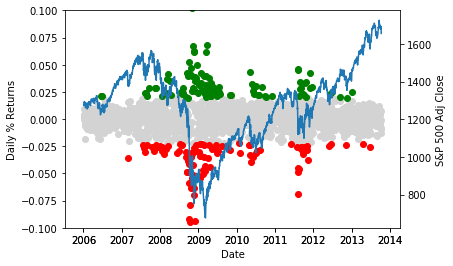

In [35]:
fig, axes1 = plt.subplots(ncols=1)

normal_mask = Y_training_anomalies['Anomaly'] == 0
axes1.scatter(Y_training_anomalies.index[normal_mask], Y_training_anomalies.loc[normal_mask]['Return'], color="lightgray")

positive_mask = Y_training_anomalies['Anomaly'] > 0
axes1.scatter(Y_training_anomalies.index[positive_mask], Y_training_anomalies.loc[positive_mask]['Return'], color="green")

negative_mask = Y_training_anomalies['Anomaly'] < 0
axes1.scatter(Y_training_anomalies.index[negative_mask], Y_training_anomalies.loc[negative_mask]['Return'], color="red")

axes1.set_ylim(-0.10, 0.10)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)
axes1.set_ylabel("Daily % Returns")
axes1.set_xlabel("Date")

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")

Text(0,0.5,'S&P 500 Adj Close')

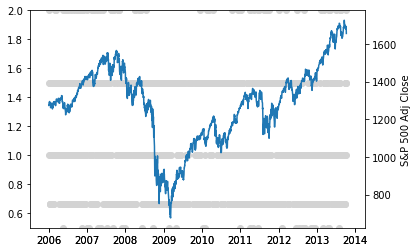

In [36]:
fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")

In [37]:
S_training_df.head()

P  N  Z       PNR  Anomaly  upperCutoff  lowerCutoff
Date                                                            
2006-01-04  3  2  0  1.500000        0          inf         0.25
2006-01-05  2  2  1  1.000000        0          inf         0.25
2006-01-06  2  1  2  2.000000        0          inf         0.25
2006-01-09  3  1  1  3.000000        0          inf         0.25
2006-01-10  1  3  1  0.333333        0          inf         0.25

### RandomForestClassifier 

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from random import randint

### DETECT

In [103]:
# lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
#             0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
#             6, 7, 8, 9, 10]

# lam_list = [0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33]

lam_list = [0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4]

prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, _, _ = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile, True)
Y_validation_anomalies, _, _ = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile, True)
Y_test_anomalies, _, _ = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile, True)

y_train = Y_training_anomalies.iloc[0:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[0:,]['Anomaly']
y_test = Y_test_anomalies.iloc[0:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:,]

#         return_threshold = 0.003
#         X_train[abs(X_train) < return_threshold] = 0 

    output_root_dir = get_output_root_dir("validation", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:,]
#         X_val[abs(X_val) < return_threshold] = 0 

    output_root_dir = get_output_root_dir("test", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:,]
#         X_test[abs(X_test) < return_threshold] = 0 

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)
#         print("\t\t Unique value in training: {0}".format(np.unique(pred_y)))
#         print("\t\t Training Accuracy: {0}".format(accuracy_score(y_train, pred_y)))

#         precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, pred_y, beta=1.0)
#         _, _recall, f2_score, _ = precision_recall_fscore_support(y_train, pred_y, beta=2.0)
#         print("\t\t Training Precision: {0}".format(precision))
#         print("\t\t Training Recall: {0}".format(recall))
#         print("\t\t Training f1 score: {0}".format(f1_score))
#         print("\t\t Training f2 score: {0}".format(f2_score))

    # What about AUROC?
#         prob_y_4 = clf.predict_proba(X_train)
#         prob_y_4 = [p[1] for p in prob_y_4]
#         print("\t\t Training ROC_AUC_SCORE: {0}".format(roc_auc_score(y_train, prob_y_4)))

    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

#         prob_y_test = clf.predict_proba(X_test)
#         prob_y_test = [p[1] for p in prob_y_test]
#         test_roc = roc_auc_score(y_test, prob_y_test)
#         print("\t\t TEST ROC_AUC_SCORE: {0}".format(test_roc))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.2000
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8948412698412699
		 TEST Precision: 0.9631944444444445
		 TEST Recall: 0.5153343388637506
		 TEST f1 score: 0.5905375164129453
		 TEST f2 score: 0.5357969072929462
	Lambda Multiplier: 0.2500
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8948412698412699
		 TEST Precision: 0.9631944444444445
		 TEST Recall: 0.5153343388637506
		 TEST f1 score: 0.5905375164129453
		 TEST f2 score: 0.5357969072929462
	Lambda Multiplier: 0.3300
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8948412698412699
		 TEST Precision: 0.9631944444444445
		 TEST Recall: 0.5153343388637506
		 TEST f1 score: 0.5905375164129453
		 TEST f2 score: 0.5357969072929462
	Lambda Multiplier: 0.5000
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8948412698412699
		 TEST Precision: 0.9631944444444445
		 TEST Recall: 0.5153343388637506
		 TEST f1 score: 0.5905375164129453
		 TEST f2 score: 0.

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
prediction_result_df.head()

Lambda  Top %  Bottom %  Test Accuracy  Test Precision  Test Recall  \
0    0.20   95.0      10.0       0.894841        0.963194     0.515334   
1    0.25   95.0      10.0       0.894841        0.963194     0.515334   
2    0.33   95.0      10.0       0.894841        0.963194     0.515334   
3    0.50   95.0      10.0       0.894841        0.963194     0.515334   
4    1.00   95.0      10.0       0.902778        0.965686     0.554047   

    Test F1   Test F2  # of Unique Values  
0  0.590538  0.535797                 3.0  
1  0.590538  0.535797                 3.0  
2  0.590538  0.535797                 3.0  
3  0.590538  0.535797                 3.0  
4  0.641159  0.579006                 3.0

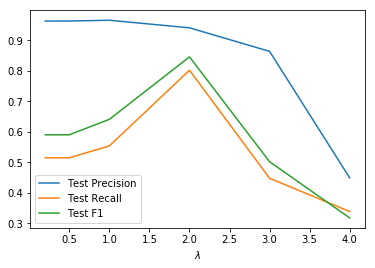

In [106]:
# result_df = pd.read_csv(r"C:\phd\rpca\debug\returns_polarity_df.csv")
# result_95pct_df = prediction_result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test Precision'])
axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test Recall'])
axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='lower left')


### PREDICT

In [100]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]


prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, _, _ = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile, True)
Y_validation_anomalies, _, _ = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile, True)
Y_test_anomalies, _, _ = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile, True)

# NOTE: We are shifting things by 1
y_train = Y_training_anomalies.iloc[1:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[1:,]['Anomaly']
y_test = Y_test_anomalies.iloc[1:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:-1,]    # notice the shift of 1

    output_root_dir = get_output_root_dir("validation", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:-1,]       # notice the shift of 1

    output_root_dir = get_output_root_dir("test", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:-1,]      # notice the shift of 1

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)
    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.0500
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.8230616302186878
		 TEST Precision: 0.33364389233954456
		 TEST Recall: 0.3412040872687103
		 TEST f1 score: 0.3295991570988085
		 TEST f2 score: 0.33553587758834674
	Lambda Multiplier: 0.0526
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8071570576540755
		 TEST Precision: 0.3345801485336369
		 TEST Recall: 0.34069778146000185
		 TEST f1 score: 0.33274104464315807
		 TEST f2 score: 0.3367484838196428
	Lambda Multiplier: 0.0556
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.805168986083499
		 TEST Precision: 0.3314123951066626
		 TEST Recall: 0.33991530884654336
		 TEST f1 score: 0.3317857462051188
		 TEST f2 score: 0.3360153256704981
	Lambda Multiplier: 0.0588
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8031809145129225


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 TEST Precision: 0.31181563534504714
		 TEST Recall: 0.32762588603516524
		 TEST f1 score: 0.31538235681236015
		 TEST f2 score: 0.32208871207815754
	Lambda Multiplier: 0.0625
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8151093439363817
		 TEST Precision: 0.41178730597817736
		 TEST Recall: 0.338605286824011
		 TEST f1 score: 0.33220981286155743
		 TEST f2 score: 0.33415427980245727
	Lambda Multiplier: 0.0667
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8151093439363817
		 TEST Precision: 0.31666666666666665
		 TEST Recall: 0.33232072171591637
		 TEST f1 score: 0.31900009327488105
		 TEST f2 score: 0.3262362637362637
	Lambda Multiplier: 0.0714
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.8151093439363817
		 TEST Precision: 0.31842105263157894
		 TEST Recall: 0.33232072171591637
		 TEST f1 score: 0.3192683695994954
		 TEST f2 score: 0.3263029944644294
	Lambda Multiplier: 0.0769
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.80318091451292

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\c

In [98]:
prediction_result_df.to_csv(r"C:\phd\rpca\debug\fama-french-predict_5pct.csv")